<a href="https://colab.research.google.com/github/iliaxant/Pattern_Recognition_HW2/blob/main/HW_2_PR_58545.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2η Εργασία**

## Αναγνώριση Προτύπων - Ακαδημαϊκό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/Pattern_Recognition_HW2

---

## **Set-Up**

1) Χειροκίνητο ανέβασμα του αρχείου *Data_exercise1.csv* και του dataset *wine.zip*.

2) Unziping του αρχείου *wine.zip*:

In [1]:
import zipfile

zip_path = '/content/wine.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

print("Data unzipped successfully to /content directory.")

Data unzipped successfully to /content directory.


3) Εγκατάσταση και φόρτωση των απαραίτητων βιβλιοθηκών:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

---

## **Άσκηση 1**

Φόρτωση των δεδομένων (*Data_exercise1.csv* αρχείο) και ομαδοποίηση ανά κλάσεις.

In [3]:
df = pd.read_csv('/content/Data_exercise1.csv', header=None)

w1 = df[df[2] == 1]
w2 = df[df[2] == 2]
w3 = df[df[2] == 3]


print('------- Contents of "data.csv": ------')
print(df)

print('\n-------------- Class 1: -------------')
print(w1)

print('\n-------------- Class 2: -------------')
print(w2)

print('\n-------------- Class 3: -------------')
print(w3)

------- Contents of "data.csv": ------
           0        1  2
0    0.53767  0.84038  1
1    1.83390 -0.88803  1
2   -2.25880  0.10009  1
3    0.86217 -0.54453  1
4    0.31877  0.30352  1
..       ...      ... ..
295  2.39140 -2.11600  3
296  2.26290 -2.81970  3
297  1.25010 -2.44910  3
298  3.91050 -2.31700  3
299  3.86710 -1.82940  3

[300 rows x 3 columns]

-------------- Class 1: -------------
           0        1  2
0   0.537670  0.84038  1
1   1.833900 -0.88803  1
2  -2.258800  0.10009  1
3   0.862170 -0.54453  1
4   0.318770  0.30352  1
..       ...      ... ..
95  0.187330  0.82606  1
96 -0.082494  1.52700  1
97 -1.933000  0.46691  1
98 -0.438970 -0.20971  1
99 -1.794700  0.62519  1

[100 rows x 3 columns]

-------------- Class 2: -------------
           0       1  2
100  3.18320  3.0799  2
101  1.97020  2.0515  2
102  3.94920  3.4115  2
103  3.30710  3.6770  2
104  3.13520  3.8577  2
..       ...     ... ..
195  2.92920  2.7901  2
196  0.51372  1.3011  2
197  3.58120  3.607

Αναπάσταση των δειγμάτων στον χώρο των χαρακτηριστικών.

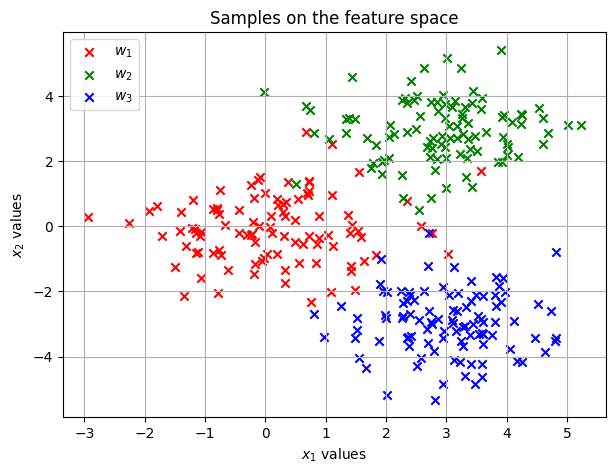

In [5]:
fig = plt.figure(figsize=(7, 5))

plt.scatter(w1[0], w1[1], color='r', marker='x', label=r'$w_1$')
plt.scatter(w2[0], w2[1], color='g', marker='x', label=r'$w_2$')
plt.scatter(w3[0], w3[1], color='b', marker='x', label=r'$w_3$')

plt.title('Samples on the feature space')
plt.xlabel("$x_1$ values")
plt.ylabel("$x_2$ values")
plt.legend()
plt.grid(True)
plt.show()

### **Α.**

Για την εκτίμηση των pdf $p(x|ω_1)$, $p(x|ω_2)$ και $p(x|ω_3)$ μέσω της μεθόδου παραθύρων Parzen χρησιμοποιείται συνάρτηση παραθύρου:

$φ(x-x_i)=\frac{1}{h_N\sqrt{2π}}e^{-\frac{||x-x_i||_{L2}^2}{2h_N^2}}$

In [14]:
def parzen_window(x, x_i, h_N):

  dist_L2 = np.sum((x - x_i) ** 2)

  return 1/(h_N * np.sqrt(2*np.pi)) * np.exp( - dist_L2 / (2 * h_N ** 2))



Έχοντας την παραπάνω συνάρτηση παραθύρου $φ(x-x_ι)$, μπορεί να υπολογιστεί η pdf $p_n(x)$ στο σημείο $x$ από την σχέση:

$p_N(x)=1/(N* h_N^2)∑_{i=1}^N{φ()}$

In [24]:

print(df.iloc[1].values)

[ 1.8339  -0.88803  1.     ]


### **Β.**

### **Γ.**

### **Δ.**

### **Ε.**

---

## **Άσκηση 2**

### **Α.**

### **Β.**

### **Γ.**

### **Δ.**

---

## **Άσκηση 3**

### **Α.**

### **Β.**

### **Γ.**

### **Δ.**

### **Ε.**